# Fitting simple isolated substorm models

The approach that is studied in this notebook is to try to select a 
simple model representing an isolated substorm iniated at time t0 and
fit the model to the real data. The fitting procedure aims to minimize
the difference between the predicted values under the models assumptions. A list of candidates is then constructed by selecting the best fitted samples. 

We will test various models in this notebook as well as different optimization approaches.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle as pkl
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get
import optim

## Load the AL index data
The first step is to load the available AL index data and perform some cleaning up (removal of duplicate values).

In [2]:
# load the data remove duplicate indexes
data_filename = "/home/aschulz/Documents/isolated_substorms/isolated_substorms/dataset.pkl"
al_data = pkl.load(open(data_filename,"rb"))
al_data=al_data[~al_data.index.duplicated(keep='first')]
al_data.head()
print("Start/Stop dates : {}/{}".format(al_data.index[0],
                                       al_data.index[-1]))

# 10m rolling average
al_data_10m = al_data.rolling(10).mean()

Start/Stop dates : 1992-01-01 00:01:00/2002-01-06 00:00:00


We have also been provided with a catalog containing onsets of isolated substorms that we load now.

In [3]:
# load the catalog
substorm_directory = "/home/aschulz/Documents/isolated_substorms/catalogs/List_substorms_Supermag/"
date_format = "%Y-%m-%d %H:%M:%S"

def load_onsets(method="ohtani"):
    filename = "{}/substorms-{}-19700101_000000_to_20210101_000000.csv".format(substorm_directory,method)
    data = pd.read_csv(filename, header=0)
    a = data["Date_UTC"].iloc[0]
    data["t"] = data["Date_UTC"].map(lambda x: datetime.strptime(x, date_format))
    return data

substorms = load_onsets("ohtani")
# remove substorms occuring before the start date of the available AL data
substorms = substorms[(substorms["t"]>al_data.index[0]) & (substorms["t"]<=al_data.index[-1])]
substorms = substorms.reset_index()
substorms.describe()


,index,MLT,MLAT,GLON,GLAT
count,9710.000000,9710.000000,9710.000000,9710.000000,9710.000000
mean,18255.500000,10.924035,67.200762,191.316616,65.498046
std,2803.179891,10.597187,3.396394,111.037909,6.221120
min,13401.000000,0.000000,40.590000,2.270000,30.350000
25%,15828.250000,1.180000,65.190000,80.570000,61.160000
50%,18255.500000,2.640000,66.440000,214.700000,64.870000
75%,20682.750000,22.600000,69.280000,282.260000,70.540000
max,23110.000000,24.000000,79.710000,358.820000,80.620000


Lets plot one of these events : the represented data starts 2 hours before the substorms onset and 4 hours after its end.

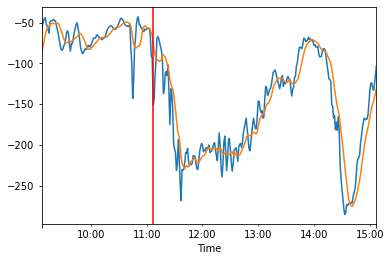

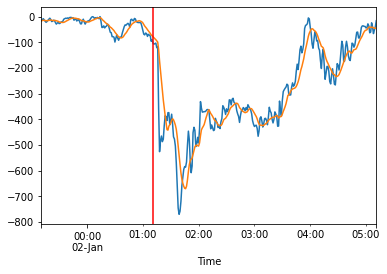

In [4]:
td = [timedelta(hours=2), timedelta(hours=4)]
event_index = 2

def plot_event(onset):
    plt.figure()
    al_data[onset-td[0]:onset+td[1]].plot()
    al_data_10m[onset-td[0]:onset+td[1]].plot()
    plt.axvline(x=onset, c="r")

for i in range(2):
    onset = substorms.iloc[i]["t"]
    plot_event(onset)


## Catalog analysis

Substorms are caracterized by a sharp decrease in value during a short time period followed by a progressive return to the original level. 

Isolated substorm are preceded and followed by "calm" periods where the AL index does not deviate too much from its mean value. 

Lets first extract some information from the catalog that may be usefull to establish a realistic model for the isolated substorms : 
    - min value on each window
    - min value 30m after onset
    - mean value before onset
    - mean difference 30m after onset
    - mean value 1h after onset to end
    - argmin - onset (seconds)
    - mean difference between onset and argmin
    - mean difference between argmin and end
    
These values are computed on the averaged data.

In [5]:
substorm_caracteristics = []
import time

def onset_caracteristics(onset):
    window = al_data_10m[onset-td[0]:onset+td[1]]
    if window.shape[0]==0:
        return np.nan * np.ones(5)
    t0 = window.index[0]
    c = [np.min(window),
                 np.min(window[onset + timedelta(minutes=30):]),
                 np.mean(window[:onset]),
                  np.mean(np.diff(window[onset:onset+timedelta(minutes=30)])),
                  np.mean(window[onset+timedelta(hours=1):]),
                  (window.idxmin()-onset).total_seconds() / 60.
                 ]
    if (window.idxmin()-onset).total_seconds() > 0.:
        c += [np.mean(np.diff(window[onset:window.idxmin()])),
             np.mean(np.diff(window[window.idxmin():]))]
    else:
        c += [np.nan, np.nan]
    return np.array(c)

tt = time.time()
substorm_carac = substorms["t"].apply(onset_caracteristics)
substorm_carac = np.array(substorm_carac.values.tolist())
print("Time : {}".format(time.time()-tt))

/home/aschulz/Documents/python/optim/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Time : 21.417920112609863


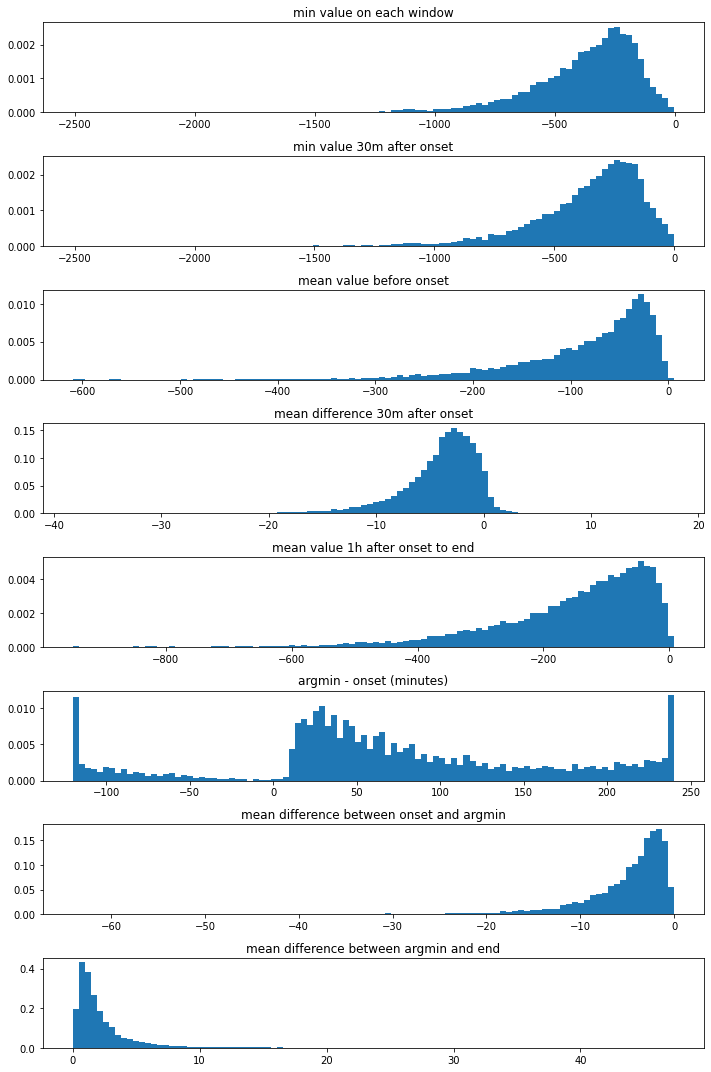

In [6]:
titles = ["min value on each window",
    "min value 30m after onset",
    "mean value before onset",
    "mean difference 30m after onset",
    "mean value 1h after onset to end",
    "argmin - onset (minutes)",
    "mean difference between onset and argmin",
    "mean difference between argmin and end",
         ]
plt.figure(figsize=(10,15))
for i in range(substorm_carac.shape[1]):
    plt.subplot(substorm_carac.shape[1], 1, i+1)
    plt.hist(substorm_carac[:,i], bins=100, density=True)
    plt.title(titles[i])
plt.tight_layout()
plt.show()

# First simple model : linear in pieces
The first model we will try to fit is very simple, it is linear in pieces , starts and ends at constant levels. 

The parameters of the model are the following : 
    - `a` : duration of the plateau before onset
    - `alpha` : value for `0 <= t < t0`
    - `b` : duration of the decrease phase
    - `beta` : rate of decrease
    - `c` : duration of the increase phase
    - `gamma` : rate of increase

The analysis of the caracteristics of the AL index surrounding the onset helps to choose bounds for these parameters : 
    - `30 <= a <= 120` : at least 30 minutes of calm before the onset
    - `-500 <= alpha <= 0` 
    - `10 <= b <= 60` : at least 10 minutes of decrease
    - `-30 <= beta <= -1`
    - `10 <= c <= 60`
    - `1 <= gamma <= 30`

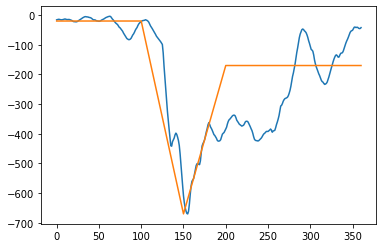

In [42]:
model1_search_space = [[30,120],
                      [-500, 0],
                      [10,60],
                      [-30,-1],
                      [10,60],
                      [1,30]]

def model1(parameters):
    # parameters
    [a,alpha,b,beta,c,gamma] = parameters
    # time is fixed
    t = np.array(list(range(361)))
    x = np.zeros(t.shape)
    
    # constant phase
    x[t < a] = alpha
    # decreasing phase
    x[(t>=a) & (t<a+b)] = alpha + beta * (t[(t>=a) & (t<a+b)] - a)
    # increasing phase
    x[(t>=a+b) & (t<a+b+c)] = (alpha + beta * b) + gamma * (t[(t>=a+b) & (t<a+b+c)] -a-b)
    # constant end
    x[t>=a+b+c] = alpha + beta * b + gamma * c
    return x

onset = substorms.iloc[1]["t"]
plt.plot(al_data_10m[onset-td[0]:onset+td[1]].values)
plt.plot(model1([100, -20, 50, -13, 50, 10]))

In [43]:
def mse_model1(parameters, onset):
    data = al_data_10m[onset-td[0]:onset+td[1]].values
    x = model1(parameters)
    r= np.mean((x -data)**2)
    if np.isnan(r):
        return 1e14
    return r
def mae_model1(parameters, onset):
    data = al_data_10m[onset-td[0]:onset+td[1]].values
    x = model1(parameters)
    return np.mean(np.abs(x-data))
print("Cost : {}".format(mse_model1([100, -20, 50, -13, 50, 10],onset)))

Cost : 13895.12836565097


RandomSearch MSE
	[112.69441583 -29.20991008  39.57281578 -13.97869863 138.99443004
   3.06749072]
	MSE = 3642.136996015259
	MAE = 47.63300698141408

RandomSearch MAE
	[112.69441583 -29.20991008  39.57281578 -13.97869863 138.99443004
   3.06749072]
	MSE = 3795.846119860301
	MAE = 45.962140717789794



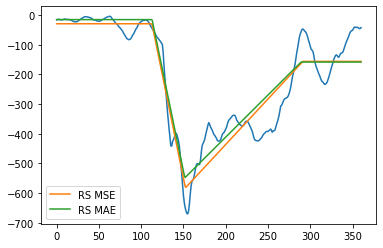

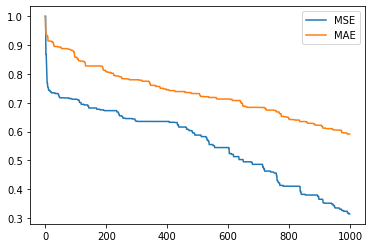

In [59]:
# random search
from optim.blackbox.random import RandomOptimizer
optimizer = RandomOptimizer()

# initial point
p0=np.array([100, -20, 50, -13, 50, 10])

# random search
rs_p_mse = optimizer.optimize(lambda x: mse_model1(x, onset), x0=p0)
mse_history = optimizer.history

rs_p_mae = optimizer.optimize(lambda x: mae_model1(x, onset), x0=p0)
mae_history = optimizer.history

plt.figure()
plt.plot(al_data_10m[onset-td[0]:onset+td[1]].values)
plt.plot(model1(rs_p_mse), label="RS MSE")
plt.plot(model1(rs_p_mae), label="RS MAE")
plt.legend()

print("RandomSearch MSE")
print("\t{}".format(rs_p_mse))
print("\tMSE = {}".format(mse_model1(rs_p_mse,onset)))
print("\tMAE = {}".format(mae_model1(rs_p_mse,onset)))
print()
print("RandomSearch MAE")
print("\t{}".format(rs_p_mse))
print("\tMSE = {}".format(mse_model1(rs_p_mae,onset)))
print("\tMAE = {}".format(mae_model1(rs_p_mae,onset)))
print()

plt.figure()
plt.plot(mse_history["evaluation"]/np.max(mse_history["evaluation"]),label="MSE")
plt.plot(mae_history["evaluation"]/np.max(mae_history["evaluation"]),label="MAE")
plt.legend()
plt.show()

CMAES
	[ 87.16981115 -71.0007804   18.60261819 -18.1022026   35.94107782
   3.89315178]
	MSE = 25782.792569300855
	MAE = 131.19977673266143

RandomSearch mean
	[113.27889048 -28.66797403  39.36014958 -14.05212722 141.55029325
   2.99284857]
	MSE = 13632.640980200058
	MAE = 93.94858357475916



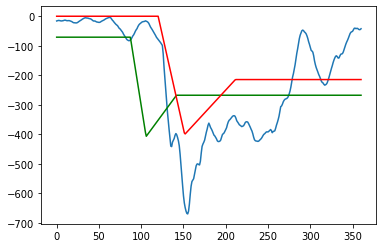

In [46]:
from optim.blackbox.cmaes import CMAES
optimizer = CMAES()

cmaes_p,cmaes_p_mean=optimizer.optimize(lambda x: mse_model1(x, onset), 
                          x0=p0, 
                          search_space=model1_search_space,
                          sigma = .3,
                          n_samples=100)
plt.plot(al_data_10m[onset-td[0]:onset+td[1]].values)
plt.plot(model1(cmaes_p),c="g",label="Pred")
plt.plot(model1(cmaes_p_mean),c="r", label="Mean")

print("CMAES")
print("\t{}".format(cmaes_p))
print("\tMSE = {}".format(mse_model1(cmaes_p,onset)))
print("\tMAE = {}".format(mae_model1(cmaes_p,onset)))
print()
print("RandomSearch mean")
print("\t{}".format(rs_p_mse))
print("\tMSE = {}".format(mse_model1(cmaes_p_mean,onset)))
print("\tMAE = {}".format(mae_model1(cmaes_p_mean,onset)))
print()

NelderMead
	[115.70267793 -26.46465685  32.71443558 -15.96203265 212.07484824
   2.37012744]
	NelderMead MSE : 3036.037807499922
	NelderMead MAE : 41.09463500923967


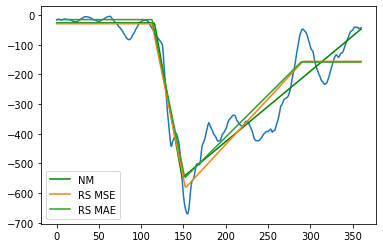

In [62]:
# Nelder-Mead
from optim.blackbox.random import NelderMead
optimizer = NelderMead()

n = p0.shape[0]
simplex = p0 + np.random.random_sample(size=(n+1,n))
nm_p=optimizer.optimize(lambda x: mse_model1(x, onset), 
                          simplex=simplex)
                          #search_space=model1_search_space,
                          #sigma = .3,
                          #n_samples=100)
plt.plot(al_data_10m[onset-td[0]:onset+td[1]].values)
plt.plot(model1(nm_p),c="g",label="NM")
plt.plot(model1(rs_p_mse), label="RS MSE")
plt.plot(model1(rs_p_mae), label="RS MAE")
plt.legend()
print("NelderMead")
print("\t{}".format(nm_p))
print("\tNelderMead MSE : {}".format(mse_model1(nm_p,onset)))
print("\tNelderMead MAE : {}".format(mae_model1(nm_p,onset)))

P0 score : 0.021663694982043114
Xmean score : 0.05772861945370113


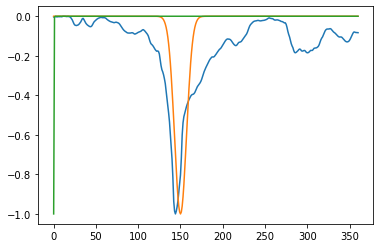

In [52]:
# fitting a normal distribution function
def normal(t, K, mu, sigma):
    return K * np.exp(-((t-mu)**2)/(sigma**2))
def scale_data(x):
    return -1. + (x - np.min(x)) / (np.max(x) - np.min(x))
def mse_normal(parameters, onset):
    data = al_data_10m[onset-td[0]:onset+td[1]].values
    data = scale_data(data)
    #print(np.sum(np.isnan(data)))
    t = np.array(list(range(data.shape[0])))
    if parameters[0] >= 0.:
        parameters[0] = -1.
    if parameters[1] < 0.:
        parameters[1]=0.
    if parameters[1] >= data.shape[0]:
        parameters[1] = data.shape[0]-1.
    if parameters[2] <= 0.:
        parameters[2]=1.
    if parameters[2] > 50.:
        parameters[2] = 50.
    x = normal(t,parameters[0],parameters[1],parameters[2])
    r= np.mean((x -data)**2)
    #r = np.mean(np.abs(x-data))
    if np.isnan(r):
        return 1e14
    return r
p0 = np.array([-1., 150, 10.])

onset1 = substorms.iloc[15]["t"]
print("P0 score : {}".format(mse_normal(p0, onset1)))

al = al_data_10m[onset1-td[0]:onset1+td[1]].values
al = scale_data(al)
tt = np.array(list(range(al.shape[0])))
plt.plot(al)
plt.plot(normal(tt, p0[0], p0[1], p0[2]))

#pp, ppp = optimizer.optimize(lambda x: mse_normal(x, onset1), 
#                          x0=p0, sigma=.001, 
#                            n_samples=1000)
pp = optimizer.optimize(lambda x: mse_normal(x, onset1), 
                          simplex=simplex)
print("Xmean score : {}".format(mse_normal(pp, onset1)))



plt.plot(normal(tt, pp[0], pp[1], pp[2]))


In [ ]:
scores = []
params = []
last_idx = np.ones(5)
for i in range(substorms.shape[0]):
    onset1 = substorms.iloc[i]["t"]
    #pp, ppp = optimizer.optimize(lambda x: mse_normal(x, onset1), 
    #                      x0=p0, sigma=.1, 
    #                        n_samples=100)
    #pp = optimizer.optimize(lambda x: mse_normal(x, onset1), 
    #                      simplex=simplex)
    pp = optimizer.optimize(lambda x: mse_model1(x, onset1), 
                          simplex=simplex)
    #scores.append(mse_normal(pp, onset1))
    scores.append(mse_model1(pp, onset1))
    params.append(pp)
    print(i, substorms.shape[0], scores[-1])
    
    if len(scores)>=5:
        #plt.figure(figsize=(10,20))
        fig, axes = plt.subplots(6,1,sharex=False,figsize=(10,20))
        scores_idx = np.argsort(scores)
        if np.all(scores_idx[:5]==last_idx):
            if not i%100==0:
                plt.close("all")
                continue
        last_idx = scores_idx[:5]
        for i in range(5):
            onset1 = substorms.iloc[scores_idx[i]]["t"]
            al = al_data_10m[onset1-td[0]:onset1+td[1]].values
            #al = scale_data(al)
            #tt = np.array(list(range(al.shape[0])))
            ppp = params[scores_idx[i]]
            #plt.subplot(5,1,i+1)
            axes[i].set_title("Onset:{}, mse:{}".format(onset1,scores[scores_idx[i]]))
            axes[i].plot(al)
            #axes[i].plot(normal(tt, ppp[0], ppp[1], ppp[2]),c="r")
            axes[i].plot(model1(ppp),c="r")
        axes[5].hist(scores, bins=100)
        plt.tight_layout()
        plt.savefig("/home/aschulz/Documents/python/optim/notebooks/best_normal_substorms.png")
        print("saved")
            
    plt.close("all")
    

0 9710 1913.930723812357
1 9710 28343.12808111016
2 9710 3617.054341899653
3 9710 20917.70363856091
4 9710 2855.51104313185
saved
5 9710 6455.167166125144
saved
6 9710 3098.502567324939
saved
7 9710 3623.1237909634815
saved
8 9710 13846.822888813764
9 9710 1825.7950014929352
saved
10 9710 4841.2018208146565
11 9710 6481.836059395886
12 9710 13872.837569100004
13 9710 3015.837690661287
saved
14 9710 14183.560694787227
15 9710 13973.073767471564
16 9710 8231.550565583038
17 9710 14940.665099593638
18 9710 3371.5127818812693
19 9710 389.29128253610406
saved
20 9710 727.8968300574455
saved
21 9710 6210.491555251397
22 9710 2765.892282073942
saved
23 9710 2870.557669161969
24 9710 5050.065824978227
25 9710 5543.13288680407
26 9710 15892.586205864864
27 9710 3794.6343862095187
28 9710 22111.524915902977
29 9710 25380.501939422553
30 9710 38453.642278508
31 9710 23817.29099679588
32 9710 2523.8514680416733
saved
33 9710 28084.171335404237
34 9710 4557.988958634796
35 9710 6413.566328857867
36

298 9710 10339.264587721975
299 9710 9454.36363600251
300 9710 25445.12254367465
saved
301 9710 16259.10404841175
302 9710 16954.298346460422
303 9710 97516.96028440086
304 9710 77476.07452250467
305 9710 17664.83150781067
306 9710 12047.037909905197
307 9710 17997.421906445463
308 9710 44495.43947851971
309 9710 47567.873529906545
310 9710 23633.52120665915
311 9710 12629.684710684805
312 9710 22894.193813190617
313 9710 18609.739767791667
314 9710 30370.704866518263
315 9710 19538.571443068955
316 9710 23801.13353682248
317 9710 16269.414940042594
318 9710 16181.647486674938
319 9710 17487.60417358498
320 9710 25232.980809942714
321 9710 16235.108242769904
322 9710 22235.87829096472
323 9710 48322.804259654455
324 9710 36479.04264229596
325 9710 18931.04240477263
326 9710 14085.067178955454
327 9710 24800.680585079717
328 9710 14582.165270938303
329 9710 6090.97390105339
330 9710 17714.748953285114
331 9710 10219.091429532446
332 9710 22875.41320185373
333 9710 16287.241063996784
334

596 9710 27119.45422174895
597 9710 34989.43687148798
598 9710 71376.81535106333
599 9710 54679.95949808665
600 9710 18858.25036908582
saved
601 9710 25467.787624106677
602 9710 35119.03378384426
603 9710 18401.401227802762
604 9710 22322.87673152252
605 9710 27310.05415014178
606 9710 21265.702387746405
607 9710 41153.50862423833
608 9710 17886.582095908303
609 9710 17621.30961895668
610 9710 15188.455806393305
611 9710 11988.627490966397
612 9710 10789.232444401301
613 9710 27192.026092852575
614 9710 6798.997376010262
615 9710 42626.271088657166
616 9710 27394.410439633513
617 9710 62392.80053990145
618 9710 35206.7450047463
619 9710 78306.82963200103
620 9710 20277.995186629763
621 9710 13975.558460829148
622 9710 30119.982404887935
623 9710 43887.15499087651
624 9710 31450.315546291935
625 9710 7559.4837402582225
626 9710 38708.93312789344
627 9710 12073.789061378517
628 9710 36590.703920950196
629 9710 24619.566365769948
630 9710 25612.15798733982
631 9710 48758.81628015718
632 9

895 9710 31859.131024613198
896 9710 38291.54903527371
897 9710 31423.176308923976
898 9710 40158.53223872652
899 9710 39503.93375296556
900 9710 28452.494182952873
saved
901 9710 34759.97535982059
902 9710 16543.18105773327
903 9710 115361.87073989109
904 9710 50034.354963557234
905 9710 41367.27233654267
906 9710 9943.7047934779
907 9710 9374.871878425547
908 9710 26646.12907476565
909 9710 37127.18662157154
910 9710 24778.797689924202
911 9710 16641.31315752036
912 9710 30663.82772484275
913 9710 19730.80473542037
914 9710 17785.440226161805
915 9710 12553.984324211933
916 9710 46049.255233433694
917 9710 33691.10075682224
918 9710 17459.1793839774
919 9710 16206.214187017691
920 9710 30883.197393876064
921 9710 90409.20755726998
922 9710 32716.89257029485
923 9710 70027.43811749417
924 9710 39949.79502368736
925 9710 28321.049231109228
926 9710 12945.140543997817
927 9710 17712.691403544108
928 9710 10871.207734513939
929 9710 29559.14468167072
930 9710 37891.81002639844
931 9710 3

In [83]:
import pickle as pkl
pkl.dump((scores, params), open("normal_substorms_sorted_temp.pkl","wb"))

In [ ]:
directory = "normal_substorms_fitting"
import os
if not os.path.exists(directory):
    os.mkdir(directory)

    
scores_idx = np.argsort(scores)
for i in range(len(scores)):
    onset1 = substorms.iloc[scores_idx[i]]["t"]
    pp = params[scores_idx[i]]
    print(i)
    plt.figure()
    al = al_data_10m[onset1-td[0]:onset1+td[1]].values
    al = scale_data(al)
    tt = np.array(list(range(al.shape[0])))
    plt.plot(al)
    plt.plot(normal(tt, pp[0], pp[1], pp[2]),c="g")
    plt.savefig("{}/cmaes_normal_{}.png".format(directory,i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/tmp/ipykernel_4906/1239306672.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
29

In [ ]:
# define the simple model function
a=60
b=30
c=30
d=60
alpha=-6.
beta=5.
gamma=5.

def model1(x):
    [a,b,c,d,alpha,beta,gamma]=x
    n = np.sum(x[:4])
    t = np.linspace(0., n, int(n)+1)
    
    x = np.ones(t.shape)
    x[t<a]=alpha
    x[(t>=a) & (t<a+b)]=alpha - beta * (t[(t>=a) & (t<a+b)] - a)
    x[(t>=a+b) & (t<a+b+c)]=(alpha - beta*b) + gamma * (t[(t>=a+b) & (t<a+b+c)] - a - b)
    x[(t>=a+b+c) & (t<=a+b+c+d)]=(alpha - beta*b) + gamma * c
    return t,x

t,x = model1([a,b,c,d,alpha,beta,gamma])
plt.plot(t,x)
t,x = model1([a+20,b,c,d,alpha,beta,gamma])
plt.plot(t,x)

In [ ]:
# try to fit this function to the first event in the catalog
real_x = data[events[0][0]-timedelta(hours=1):events[0][1]+timedelta(hours=1)]
real_x = real_x.values

t,x = model1([a,b,c,d,alpha,beta,gamma])
plt.plot(real_x)
plt.plot(x)

# define a cost function that will be minimized by random search
def J1(x):
    t,x=model1(x)
    if x.shape[0]>real_x.shape[0]:
        x = x[:real_x.shape[0]]
    X = np.zeros(real_x.shape)
    X[:x.shape[0]] = x
    X[x.shape[0]:] = real_x[x.shape[0]:]
    a= np.mean((x - np.nan_to_num(real_x[:x.shape[0]]))**2)
    return a
    return np.mean(np.abs(x - real_x[:x.shape[0]]))
    return np.mean(np.abs(X-real_x))

p = np.array([a,b,c,d,alpha,beta,gamma])
print("Cost : {}".format(J1(p)))

In [ ]:
search_space = [[60,180],[30,60],[30,60],[60,180],[-1000.,0.],[5.,50.],[5.,50.]]

def is_in_search_space(x, search_space):
    for xi,interval in zip(x, search_space):
        if xi < interval[0] or xi>interval[1]:
            return False
    return True

def coerce_to_search_space(x, search_space):
    if search_space is None:
        return x
    for i in range(len(search_space)):
        if x[i] < search_space[i][0]:
            x[i]=search_space[i][0]
        if x[i]>search_space[i][1]:
            x[i]=search_space[i][1]
    return x

def make_samples(x0, n_samples, search_space=None):
    sample_shape = [n_samples]+list(x0.shape)
    x = x0 + 2.*(np.random.normal(size=sample_shape)-.5)
    if search_space is None:
        iiss = np.ones(n_samples)
    else:
        iiss = np.array([is_in_search_space(xi, search_space) for xi in x])
    # search space coersion
    x = np.array([coerce_to_search_space(xi, search_space) for xi in x])
    return x

    while np.sum(iiss)!=n_samples:
        print(np.sum(iiss), n_samples)
        # draw new samples
        nss = [int(np.sum(~iiss))]+list(x0.shape)
        x[~iiss] = x0 + np.random.random_sample(size=nss)
        iiss[~iiss] = np.array([is_in_search_space(xi, search_space) for xi in x[~iiss]])
    return x

def random_search(func, x0, n_samples=100, max_iter=10000, search_space=None, patience=None):
    it = 0
    # sample shape
    sample_shape = [n_samples]+list(x0.shape)
    history=[]
    no_improvement=0
    while it < max_iter:
        # draw samples around the current candidate
        samples = make_samples(x0, n_samples, search_space)
        #samples = x0 + 2*(np.random.random_sample(size=sample_shape)-.5)
        #iiss = np.array([is_in_search_space(xi, search_space) for xi in samples])
        #ii=0
        #while np.sum(iiss)!=iiss.shape[0]:
        #    nss = sample_shape
        #    nss[0] = np.sum(~iiss)
        #    samples[~iiss] = x0 + 2*(np.random.random_sample(size=nss)-.5)
        #    iiss = np.array([is_in_search_space(xi, search_space) for xi in samples])
            #print("new", iiss,ii)
        #    ii+=1
        # check that the samples are in the search space
        samples = np.vstack((samples, x0))
        # evaluate the samples
        evaluations = np.array([func(xi) for xi in samples])
        # keep the best
        if np.all(x0 == samples[np.argmin(evaluations)]):
            no_improvement += 1
            if patience is not None:
                if no_improvement == patience:
                    break
        else:
            no_improvement = 0
        x0 = samples[np.argmin(evaluations)]
        # history 
        history.append(np.min(evaluations))
        # next iteration
        it += 1
    return x0, history

#p0,history = random_search(J1,p,patience=100)
#print("p0 : {}".format(p0))
#t,x = model1(p0)
#plt.plot(real_x)
#plt.plot(x)

#plt.figure()
#plt.plot(history)
#print("Final evaluation : {}".format(history[-1]))

In [ ]:
scores = []
full_data = data.rolling(10).mean()
print("full data shape : {}".format(full_data.shape))
print(0, full_data.shape[0] - 8*60, 8*60)
for i in range(0, full_data.shape[0] - 8*60, 8*60):
    p = np.random.random_sample(size=len(search_space))
    for j in range(len(search_space)):
        p[j] = search_space[j][0]+(search_space[j][1]-search_space[j][0])*p[j]
    #print(p)
    real_x = full_data.iloc[i:i+8*60].values
    p0,history = random_search(J1,p,patience=300)
    scores.append(history[-1])
    
    print(i, len(history), scores[-1],p0)
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.plot(history)
    plt.subplot(3,1,2)
    plt.plot(real_x)
    t,x = model1(p0)
    plt.plot(x)
    plt.subplot(3,1,3)
    plt.plot(scores)
    plt.savefig("scores_model1.png")
    plt.close("all")

plt.plot(scores)

In [ ]:
sorted_args = np.argsort(scores)
c=0
for i in sorted_args:
    pos = i*8*60
    plt.figure()
    plt.plot(full_data.iloc[pos:pos+8*60].values)
    #t,x = model1(params[i])
    #plt.plot(x)
    plt.show()
    plt.close("all")
    c+=1
    if c>100:
        break

In [ ]:
def model2(p, t):
    [a,b,alpha,beta,lambd,eps]=p
    x=np.zeros(t.shape)
    x[t<a] = alpha
    x[(t>=a) & (t<a+b)]=alpha + beta*(t[(t>=a) & (t<a+b)] - a)
    x[t>=a+b] = (alpha + beta*b)* np.exp(lambd * (t[t>=a+b]-a-b))
    return x
t = np.linspace(0,8*60, 8*60+1)
x = model2([120, 30, -10, -5, -.01, -10], t)
plt.plot(t, x)

In [ ]:
# try to fit this function to the first event in the catalog
real_x = data[events[0][0]-timedelta(hours=1):events[0][1]+timedelta(hours=1)]
real_x = real_x.values

t = np.array(list(range(real_x.shape[0])))

x = model2([120, 30, -10, -5, -.01, -10], t)
plt.plot(real_x)
plt.plot(x)

# define a cost function that will be minimized by random search
def J2(x):
    x=model2(x,t)
    if x.shape[0]>real_x.shape[0]:
        x = x[:real_x.shape[0]]
    X = np.zeros(real_x.shape)
    X[:x.shape[0]] = x
    X[x.shape[0]:] = real_x[x.shape[0]:]
    a= np.mean((x - np.nan_to_num(real_x[:x.shape[0]]))**2)
    return a
    return np.mean(np.abs(x - real_x[:x.shape[0]]))
    return np.mean(np.abs(X-real_x))

p = np.array([120, 30, -10, -5, -.01, -10])
print("Cost : {}".format(J2(p)))

In [ ]:
p0,history = random_search(J2,p,patience=100)
print("p0 : {}".format(p0))
x = model2(p0, t)
plt.plot(real_x)
plt.plot(x)

plt.figure()
plt.plot(history)
print("Final evaluation : {}".format(history[-1]))

In [ ]:
scores = []
full_data = data.rolling(10).mean()
print("full data shape : {}".format(full_data.shape))
print(0, full_data.shape[0] - 8*60, 8*60)
search_space = [[60,120],
                [30,60],
                [-100.,0.],
                [-100, 0],
                [-10, -1e-6],
                [-100, 0]]
for i in range(0, full_data.shape[0] - 8*60, 8*60):
    p = np.random.random_sample(size=len(search_space))
    for j in range(len(search_space)):
        p[j] = search_space[j][0]+(search_space[j][1]-search_space[j][0])*p[j]
    #print(p)
    real_x = full_data.iloc[i:i+8*60].values
    p0,history = random_search(J2,p,patience=300)
    scores.append(history[-1])
    
    print(i, len(history), scores[-1],p0)
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,1)
    plt.plot(history)
    plt.subplot(3,1,2)
    plt.plot(real_x)
    t = np.array(list(range(real_x.shape[0])))
    x = model2(p0,t)
    plt.plot(x)
    plt.subplot(3,1,3)
    plt.plot(scores)
    plt.savefig("scores_model2.png")
    plt.close("all")

plt.plot(scores)

In [ ]:
def update_mean(x, s, mu):
    return np.mean(x[s[:mu]], axis = 0)
def update_ps(ps, X):
    
def cma_es(func, x0, max_iter=1000, n_samples=10, sigma=1.):
    C = np.eye(x0.shape)
    it = 0
    m = x0
    mu = int(n_samples/2) # number of samples used to update the mean
    ps = 0.
    while it != max_iter:
        # draw the new samples
        x = np.random.multivariate_normal(loc = m, cov = (sigma**2) * C, size=n_samples)
        # evaluate
        f = np.array([func(xi) for xi in x])
        # sort the evaluations
        s = np.argsort(f)
        # update the mean
        mt = m
        m = update_mean(x, s)
        # 
        